In [68]:
## Kütüphaneler
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy.random as rnd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin

import warnings;
warnings.filterwarnings('ignore')



###Veri yükleme
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [69]:
## Veri inceleme
print(data.describe(),"\n")
data.info()

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

In [70]:
### Missing value kontrol edilmesi
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [71]:
## Eksik verilerin ortalama değerleriyle değiştirilmesi 
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median") 
data_num = data.drop("ocean_proximity", axis=1)
imputer.fit(data_num) 

X_num = imputer.transform(data_num)
X_num = pd.DataFrame(X_num, columns=data_num.columns,
                          index = list(data_num.index.values))

In [72]:
data.shape

(20640, 10)

In [73]:
X_num.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [74]:
### Kategorik verilerin sayısal verilere dönüştürülmesi
data["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [75]:
data = data.replace('ISLAND', 'NEAR BAY')
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2295
Name: ocean_proximity, dtype: int64

In [76]:
X_cat = pd.DataFrame(data["ocean_proximity"])
X_cat = pd.get_dummies(X_cat['ocean_proximity'] , drop_first=True)
X_cat.head()

,INLAND,NEAR BAY,NEAR OCEAN
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


### Verilerin görselleştirilmesi 

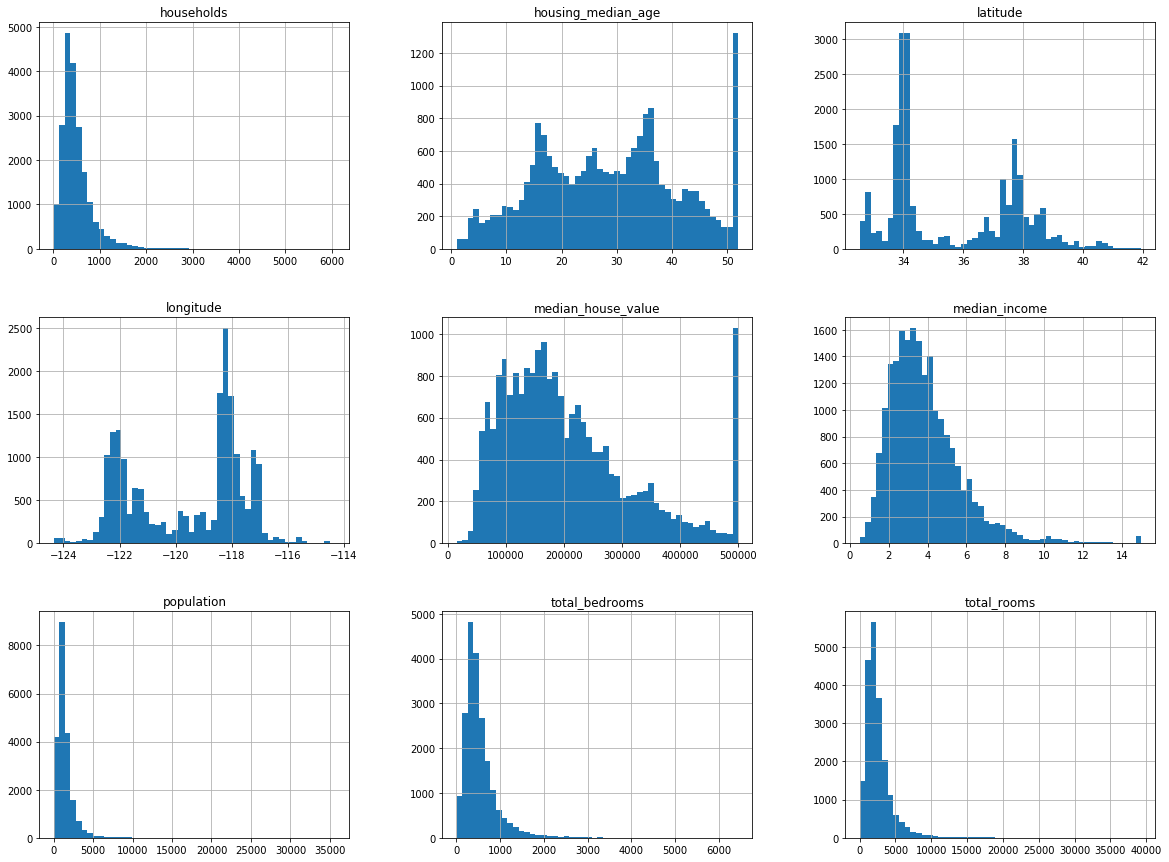

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

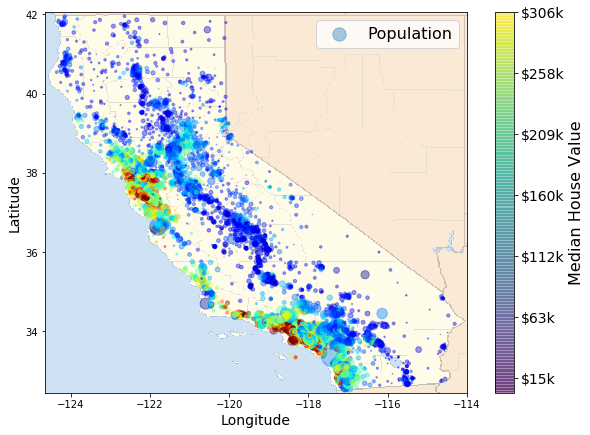

In [78]:
### Konumlara göre populasyon ve ev fiyatlarının heatmap ile görselleştirilmesi
import matplotlib.image as mpimg
california_img=mpimg.imread('california.png')
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=data['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.65, -114.0, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [79]:
corr_matrix = X_num.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Veri setini incelemeden önce oda sayısı, yatak odası sayısı değişkenlerinin daha iyi modeli açıklamasını düşünüyordum fakat veri setini incelediğimizde bu değişkenlerin korelasyon katsayısının 0 a yakın olduğunu gördüm.

In [80]:
### Yeni değişken oluşturulması
X_num["rooms_per_household"] = X_num["total_rooms"]/data["households"] 
X_num["bedrooms_per_room"] = X_num["total_bedrooms"]/data["total_rooms"] 
X_num["population_per_household"]=X_num["population"]/data["households"]

In [81]:
corr_matrix = X_num.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.233303
Name: median_house_value, dtype: float64

Yeni kolonlar eklenmeden önce ki korelasyon katsayılarıyla karşılaştırdığımızda :

bedrooms_per_room(0.255880) > total_rooms(0.134153) veya total_bedrooms(0.049686)

rooms_per_household(0.151948) > total_rooms(0.134153) veya households(0.065843)

population_per_household(0.023737) >population(0.024650) veya households(0.065843)

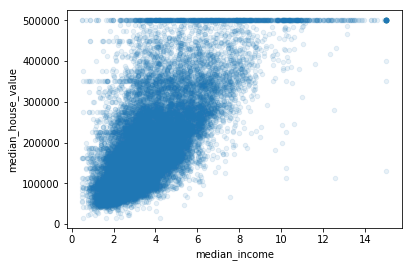

In [82]:
### Outlier değerlerin bulunması
data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

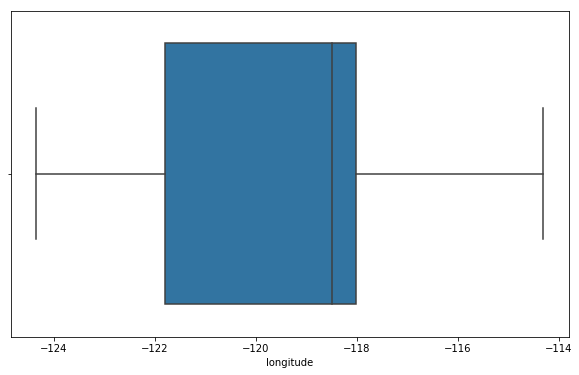

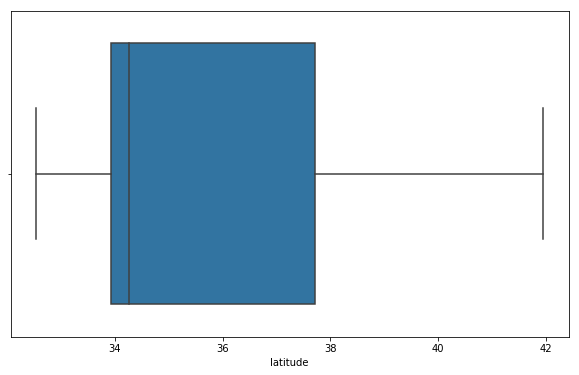

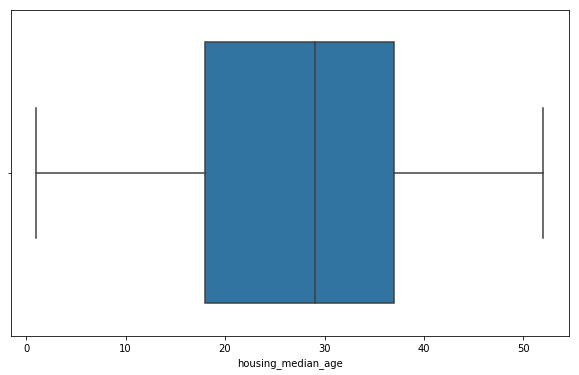

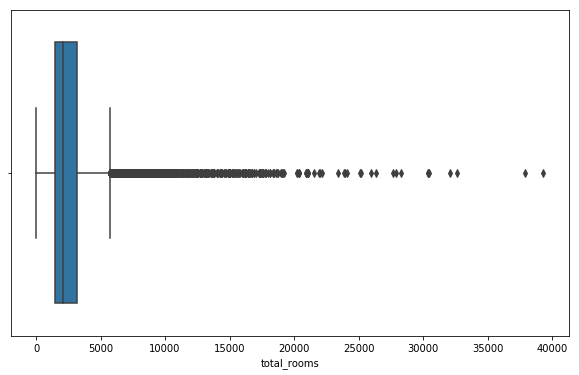

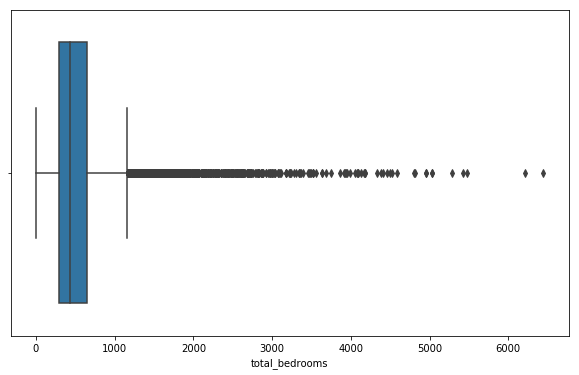

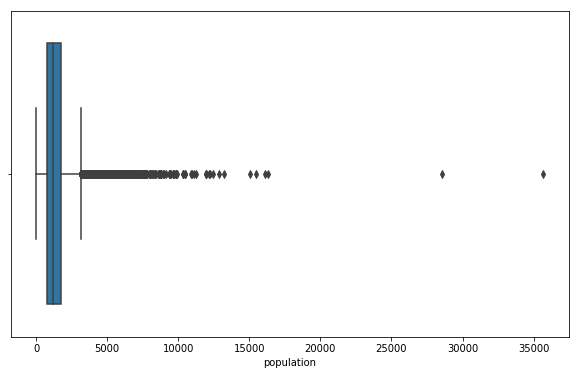

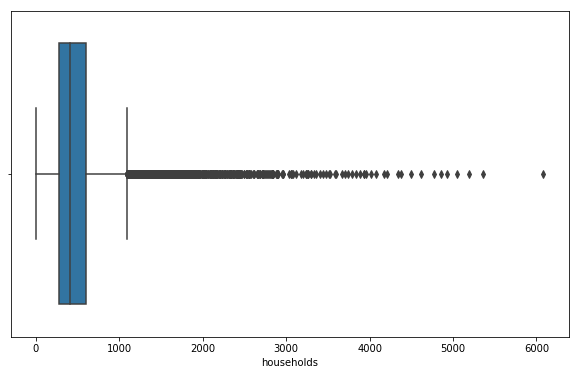

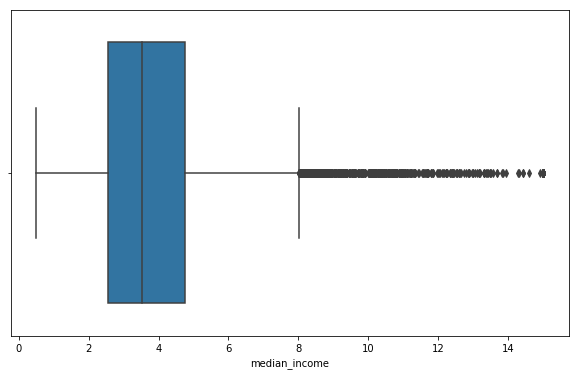

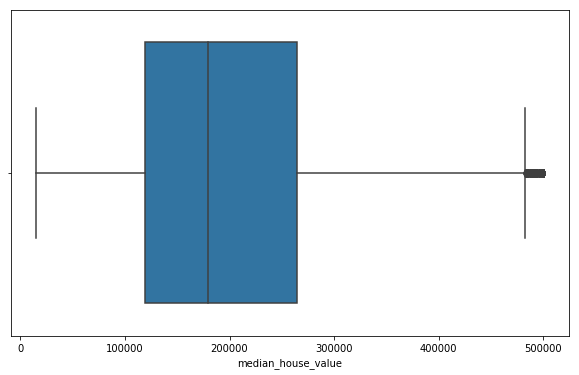

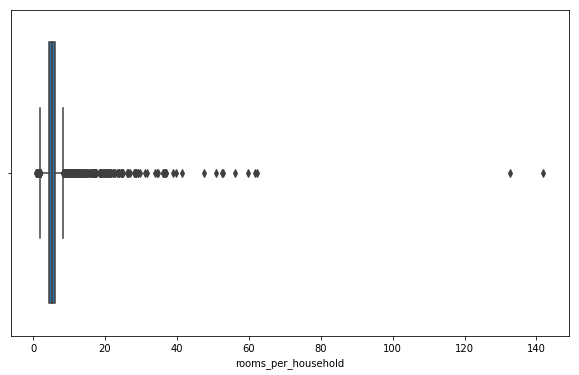

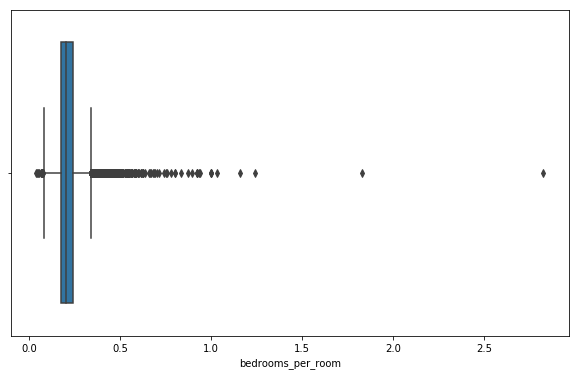

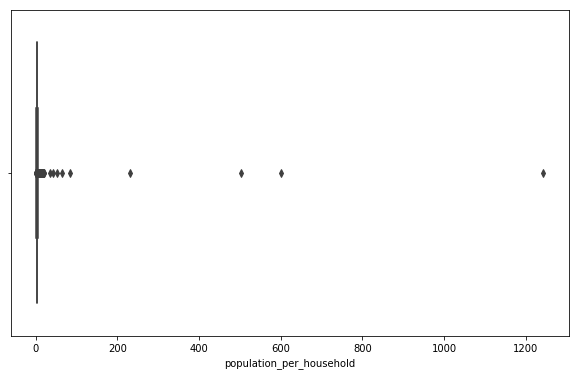

In [83]:
for i in X_num.columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    #plt.xlim(-10,10)
    sns.boxplot(x=i,data=X_num,ax=ax)

In [84]:
def removeOutlier(data):
    data=data[(data['median_house_value']!=500001) | (data['median_income']>=2)].reset_index(drop=True)
    data=data[data['median_income']<=11].reset_index(drop=True)
    data=data[(data['median_house_value']!=500001) | (data['median_income']>=11)].reset_index(drop=True)
    data=data[(data['median_house_value']!=350000) | (data['median_income']>=1.5)].reset_index(drop=True)
    data=data[(data['median_house_value']!=450000) | (data['median_income']>=2)].reset_index(drop=True)
    data=data[(data['median_house_value']>=350000) | (data['median_income']<=9.5)].reset_index(drop=True)
    data=data[data['population']<=9000]
    data=data[(data['population_per_household']>=1.15) & (data['population_per_household']<=6.5)]  
    data=data[data['rooms_per_household']<20]
    data=data[data['bedrooms_per_room']<0.5].reset_index(drop=True)
    return data

In [85]:
## Preprocessing sonrası onrası datanın oluşturulması 
print('Kategorik dataların boyutu',X_cat.shape)
print('Sayısal dataların boyutu',X_num.shape)
## Outlier silmeden önce

Kategorik dataların boyutu (20640, 3)
Sayısal dataların boyutu (20640, 12)


In [86]:
X_num.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556


In [87]:
X_num.skew(axis = 0, skipna = True)

longitude                   -0.297801
latitude                     0.465953
housing_median_age           0.060331
total_rooms                  4.147343
total_bedrooms               3.481141
population                   4.935858
households                   3.410438
median_income                1.646657
median_house_value           0.977763
rooms_per_household         20.697869
bedrooms_per_room            6.316904
population_per_household    97.639561
dtype: float64

In [88]:
def FutureTransformer(X):
    from scipy.special import boxcox1p        
    X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
    X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
    X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
    X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
    X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
    X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
    X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
    X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
    return X    

In [89]:
X_num.skew(axis = 0, skipna = True)

longitude                   -0.297801
latitude                     0.465953
housing_median_age           0.060331
total_rooms                  4.147343
total_bedrooms               3.481141
population                   4.935858
households                   3.410438
median_income                1.646657
median_house_value           0.977763
rooms_per_household         20.697869
bedrooms_per_room            6.316904
population_per_household    97.639561
dtype: float64

In [90]:
data = X_num.merge(X_cat, left_index=True, right_index=True)
print(data.shape)
before = data.shape[0]
data.head()

(20640, 15)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,INLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,0,1,0


In [91]:
data = removeOutlier(data)
data.shape
print( before- data.shape[0])

1267


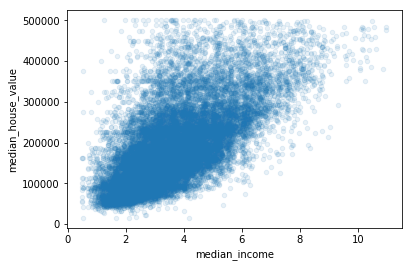

In [92]:
data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [93]:
data = FutureTransformer(data)

In [94]:
data.skew(axis = 0, skipna = True)

longitude                  -0.290901
latitude                    0.457534
housing_median_age          0.067742
total_rooms                 0.222414
total_bedrooms              0.208788
population                  0.268379
households                 -0.048053
median_income               0.094054
median_house_value          0.805736
rooms_per_household        -0.016570
bedrooms_per_room           0.387728
population_per_household    0.258302
INLAND                      0.723652
NEAR BAY                    2.533298
NEAR OCEAN                  2.274848
dtype: float64

In [95]:
data.shape

(19373, 15)

In [96]:
data_num = data.drop("NEAR OCEAN", axis=1)
data_num = data_num.drop("NEAR BAY", axis=1)
data_num = data_num.drop("INLAND", axis=1)

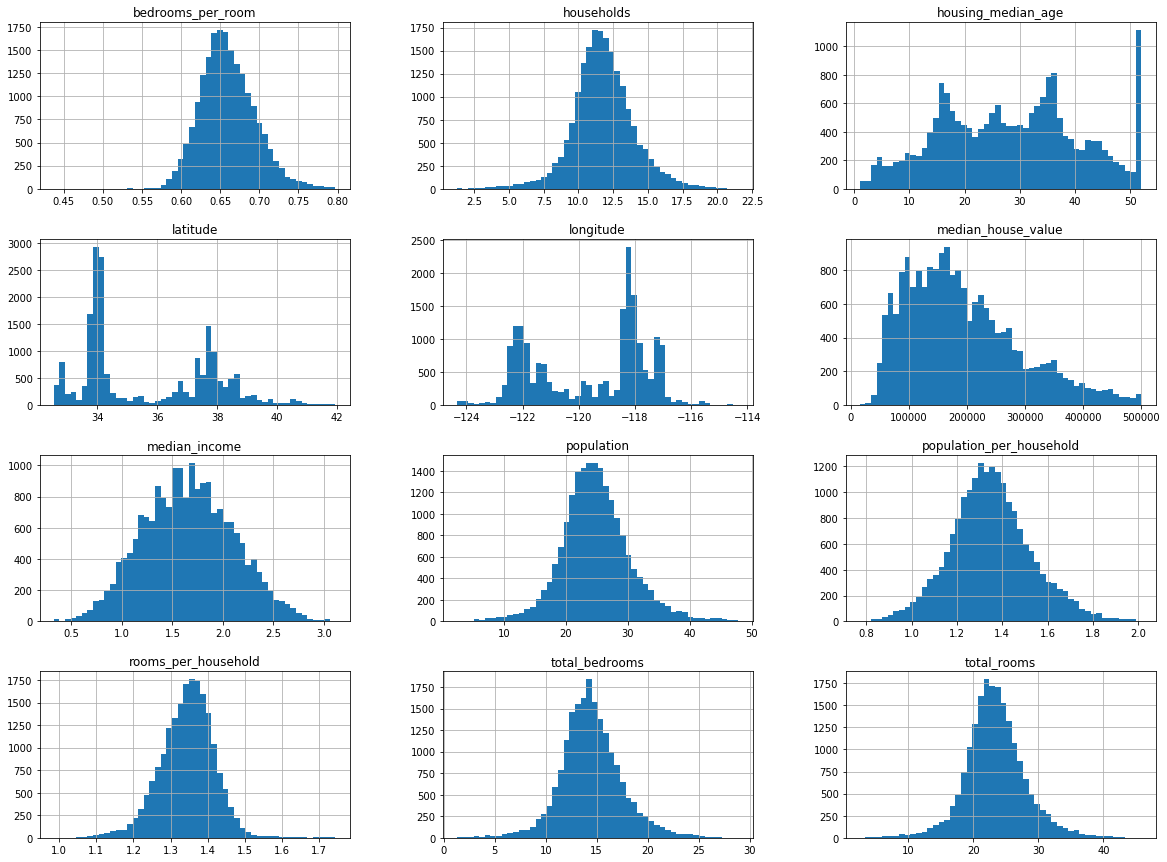

In [97]:
data_num.hist(bins=50, figsize=(20,15))
plt.show()

### Model Building

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X = data.drop("median_house_value", axis=1) 
y =data["median_house_value"].copy() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size : {} , Test size : {} ".format(X_train.shape[0], X_test.shape[0]))

Train size : 15498 , Test size : 3875 


In [99]:
test_scaler = StandardScaler()
y_test = test_scaler.fit_transform = (y_test)

In [100]:
###Model Building 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

RFE_lin_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(LinearRegression(), verbose=0)),
    ('lin_reg', LinearRegression())
])
RFECV_lin_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(LinearRegression(), min_features_to_select=5, scoring='r2'  ,verbose=0, n_jobs=-1)),
    ('lin_reg', LinearRegression())
])

In [101]:
# Future selection öncesi 
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
print()

print("Future Selection Öncesinde Train-Test Score \n Train Score :",regression_model.score(X_train, y_train), " \n Test Score : ",regression_model.score(X_test, y_test))


Future Selection Öncesinde Train-Test Score 
 Train Score : 0.6294293202883826  
 Test Score :  0.6425039688512639


In [102]:
### Rfe
reg = RFE_lin_reg_pipeline.fit(X_train, y_train)
print("RFE Train-Test Score \n Train Score : ",reg.score(X_train, y_train), " \n Test Score : ",reg.score(X_test, y_test))


RFE Train-Test Score 
 Train Score :  0.6084288018666452  
 Test Score :  0.6183460489114929


In [103]:
#### RFECV 
reg2 = RFECV_lin_reg_pipeline.fit(X_train, y_train)
reg2.score(X_train, y_train)
print("RFECV Train-Test Score \n Train Score : ",reg2.score(X_train, y_train), " \n Test Score : ",reg2.score(X_test, y_test))

RFECV Train-Test Score 
 Train Score :  0.6294293202883826  
 Test Score :  0.6425039688512635


In [104]:
print('Best features :', X.columns[reg2.named_steps['feature_selection'].support_])

Best features : Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'INLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')


In [105]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg2, X_train, y_train,
                        scoring="r2", cv=10)
print("10'lu Cross-Validation ortalama r2 değeri", scores.mean())

10'lu Cross-Validation ortalama r2 değeri 0.6281528834939744


In [106]:
scores2 = cross_val_score(reg2, X_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores2)

In [107]:
print("RMSE : ",rmse_scores.mean(),"   Std  :", rmse_scores.std())

RMSE :  59340.73637249939    Std  : 1659.431954454932


In [38]:
### GradientBoosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
gbr=GradientBoostingRegressor(random_state=42)
param_grid={
    'n_estimators':[100,500,1000],
    'max_depth':range(3,9,1),
    'max_features':[6,7,9,11,12,13,14],
    'min_samples_split':[200,400]  
}
scoring='r2'
grid=GridSearchCV(gbr,param_grid,scoring=scoring,n_jobs=-1,cv=3,verbose=1)
grid.fit(X_train,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 21.9min finished


{'max_depth': 8, 'max_features': 9, 'min_samples_split': 200, 'n_estimators': 500}


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_Regressor=GradientBoostingRegressor(max_depth=8, max_features=9, min_samples_split=200, n_estimators=500, random_state=42)
scores=cross_val_score(gbr_Regressor,X_train,y_train,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')

In [40]:
scores.mean()

0.8240462776520691

In [41]:
gbr_Regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=9,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=200, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

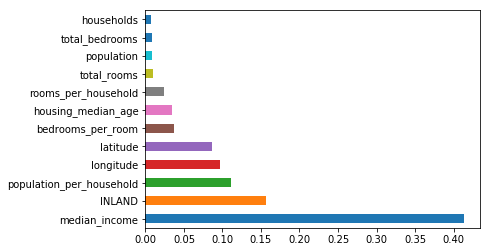

In [42]:
feat_importances = pd.Series(gbr_Regressor.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()


In [43]:
from sklearn.metrics import r2_score
predict = gbr_Regressor.predict(X_test)
r2_score(y_test, predict)

0.8294851528331064